In [1]:
csv_file_path = 'cleaned_train_data/cleaned_train_data.csv'
output_folder = 'doublechecking/'
input_folder = 'cleaned_train_data/cleaned_stage_2_train_images/'

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pydicom
import gc
import pandas as pd
from skimage.measure import find_contours

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_mask2(mask, ax, random_color=False):
    # Determine color for the outline
    if random_color:
        color = np.random.random(3)
    else:
        color = np.array([30/255, 144/255, 255/255])
    
    h, w = mask.shape[-2:]
    
    # Create an outline by using contours
    contours = np.zeros((h, w), dtype=np.uint8)
    contours[mask > 0] = 1  # Create a binary mask where the original mask is present
    contours = np.pad(contours, pad_width=1, mode='constant', constant_values=0)
    
    # Find the contours
    contours_found = find_contours(contours, 0.5)

    # Plot contours
    for contour in contours_found:
        ax.plot(contour[:, 1] - 1, contour[:, 0] - 1, color=color, linewidth=2)  # Adjust for padding

# Create a dictionary with patientId as keys and list of bounding box coordinates as values
df = pd.read_csv(csv_file_path)
bounding_boxes_dict = df.groupby('patientId')[['x1', 'y1', 'x2', 'y2']].apply(lambda x: x.values.tolist()).to_dict()

In [3]:
def apply_clahe_to_array(image_array, clip_limit, tile_grid_size):
    # print(f"Applying CLAHE with clipLimit={clip_limit}, tileGridSize={tile_grid_size}")
    # Normalize image to 0-255 and convert to uint8
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=5)
    # Apply CLAHE
    clahe_image = clahe.apply(image_array) + 30
    return clahe_image

def apply_canny_to_array(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    otsu_threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lower_threshold = int(otsu_threshold * 0.1)
    upper_threshold = int(otsu_threshold * 0.5)
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    combined_image = cv2.addWeighted(image, 0.3, edges, 0.7, 0)
    return combined_image

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    else:
        return intersection / union

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [5]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor2 = SAM2ImagePredictor(sam2_model)
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

0


c:\Users\shere\AppData\Local\Programs\Python\Python312\Lib\site-packages\sam2\modeling\backbones\hieradet.py:68: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
c:\Users\shere\AppData\Local\Programs\Python\Python312\Lib\site-packages\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
c:\Users\shere\AppData\Local\Programs\Python\Python312\Lib\site-packages\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\

Confidence score: 0.7265625
Confidence score: 0.76953125


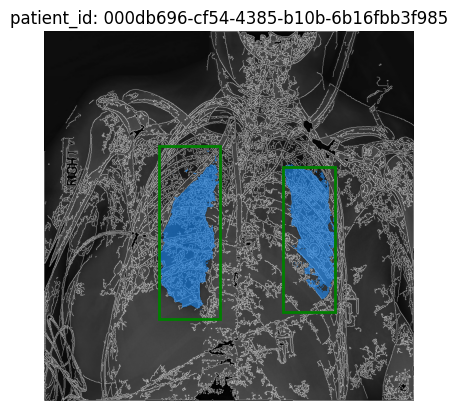

In [6]:
# Iterate through the first 2 keys of the bounding_boxes_dict
counter = 0
for patient_id, boxes in list(bounding_boxes_dict.items())[:1]:  # Process the first entry
    print(counter)
    counter += 1
    
    # Read the DICOM file for the current patient_id
    dcm_file_path = f'cleaned_train_data/cleaned_stage_2_train_images/{patient_id}.dcm'
    output_image_path = f'{output_folder}{patient_id}_sam2_masked.png'
    dicom = pydicom.dcmread(dcm_file_path)
    
    # Convert to 3-channel RGB image if needed by SAM
    image = dicom.pixel_array
    image = np.array(image)
    
    # Apply CLAHE and Canny edge detection
    clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32,32))
    clahe_canny_image = apply_canny_to_array(clahe_image)
    
    # Convert images to RGB
    clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)
    
    # Display the processed image
    plt.imshow(clahe_canny_image_rgb)
    plt.title(f"patient_id: {patient_id}")
    
    # Set the processed image in SAM's predictor
    predictor2.set_image(clahe_canny_image_rgb)

    # Initialize an empty list to hold all the masks and scores
    all_masks = []
    all_scores = []

    # Loop over each bounding box and predict masks one at a time
    for box in boxes:
        input_box = np.array(box)
        
        # Obtain masks and scores for each bounding box
        masks, scores, _ = predictor2.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # Use individual bounding box
            multimask_output=False
        )
        
        # Append the mask and confidence score
        all_masks.append(masks[0])  # Store the mask for each box
        all_scores.append(scores[0])  # Store the confidence score for each mask

    # Display the results and confidence scores
    for mask, score, box in zip(all_masks, all_scores, boxes):
        show_mask(mask, plt.gca())  # Display mask
        show_box(box, plt.gca())
        print(f"Confidence score: {score}")  # Print confidence score for each mask
    
    plt.axis('off')
    # plt.savefig(output_image_path, format='png', dpi=300)  # Save the output image if needed
    plt.show()
    
    # Cleanup to free memory
    plt.clf()
    plt.close('all')
    del dicom, image, clahe_image, clahe_canny_image_rgb, all_masks, all_scores
    gc.collect()


In [7]:
def modify_bounding_boxes(boxes, translation_range=5, scale_range=0.1):
    modified_boxes = []

    for box in boxes:
        for i in range(4):
          # Extract coordinates
          x1, y1, x2, y2 = box

          # Apply random translation
          tx = np.random.randint(-translation_range, translation_range + 1)
          ty = np.random.randint(-translation_range, translation_range + 1)

          # Apply random scaling
          scale_factor = 1 + np.random.uniform(-scale_range, scale_range)
          width = x2 - x1
          height = y2 - y1
          new_width = width * scale_factor
          new_height = height * scale_factor

          # Calculate new coordinates
          new_x1 = int(x1 + tx)
          new_y1 = int(y1 + ty)
          new_x2 = int(new_x1 + new_width)
          new_y2 = int(new_y1 + new_height)

          modified_boxes.append([new_x1, new_y1, new_x2, new_y2])
          #print(modified_boxes)

    return np.array(modified_boxes)

import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Function to train a non-linear regression model
def train_regression_model(modified_boxes, sam_scores, consistency_scores):
    # Combine modified boxes and SAM scores as features
    X = np.hstack([modified_boxes, sam_scores])  # Combine as rows of features
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X, consistency_scores)
    return model

# Function to predict consistency scores
def predict_consistency(model, modified_boxes, sam_scores):
    X_new = np.hstack([modified_boxes, sam_scores])
    predictions = model.predict(X_new)
    return predictions

In [10]:
# Initialize lists to hold each row for the final DataFrame and regression model data
data_rows = []
total_bounding_boxes = sum(len(boxes) for boxes in bounding_boxes_dict.values())
modified_boxes = np.zeros(shape=(total_bounding_boxes, 4, 4))
sam_scores = np.zeros(shape=(total_bounding_boxes, 4))
consistency_scores_before = np.zeros(shape=(total_bounding_boxes))
consistency_scores_after = np.zeros(shape=(total_bounding_boxes))
index = 0

iteration = 0  # Track the current iteration

# Loop through each patient and bounding box set
for patient_id, boxes in list(bounding_boxes_dict.items())[:1]:  # Iterating through each patient and their boxes
    print(f"Processing patient_id: {patient_id} ({iteration + 1}/4500)")
    iteration += 1

    # Read the DICOM file for the current patient_id
    dcm_file_path = f'{input_folder}{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    image = np.array(dicom.pixel_array)

    # Loop through each bounding box
    for box in boxes:
        perturbed_boxes = modify_bounding_boxes([box])

        # Initialize placeholders for SAM scores
        sam_scores_no_prep = np.zeros(len(perturbed_boxes))
        sam_scores_with_prep = np.zeros(len(perturbed_boxes))

        # Pass the original image to SAM for feature extraction
        predictor2.set_image(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

        # Compute SAM scores without preprocessing
        for i, perturbed_box in enumerate(perturbed_boxes):
            input_box = np.array(perturbed_box)
            masks, scores, _ = predictor2.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            best_idx = np.argmax(scores)
            sam_scores_no_prep[i] = scores[best_idx]

        # Calculate consistency score and average SAM score without preprocessing
        consistency_score_before = np.std(sam_scores_no_prep)
        average_sam_score_before = np.mean(sam_scores_no_prep)

        # Apply CLAHE and Canny edge detection for preprocessing
        clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32, 32))
        clahe_canny_image = apply_canny_to_array(clahe_image)
        clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)
        predictor2.set_image(clahe_canny_image_rgb)

        # Compute SAM scores with preprocessing
        for i, perturbed_box in enumerate(perturbed_boxes):
            input_box = np.array(perturbed_box)
            masks, scores, _ = predictor2.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            best_idx = np.argmax(scores)
            sam_scores_with_prep[i] = scores[best_idx]

        # Calculate consistency score and average SAM score with preprocessing
        consistency_score_after = np.std(sam_scores_with_prep)
        average_sam_score_after = np.mean(sam_scores_with_prep)

        # Store in arrays for model training
        for j in range(4):
            modified_boxes[index][j] = perturbed_boxes[j]
            sam_scores[index][j] = sam_scores_with_prep[j]

        # Store the consistency scores and average SAM scores
        consistency_scores_before[index] = consistency_score_before
        consistency_scores_after[index] = consistency_score_after

        # Append to data_rows with new average SAM score columns
        data_rows.append({
            'patient_id': patient_id,
            'consistency_score_before': consistency_score_before,
            'consistency_score_after': consistency_score_after,
            'sam_score_before': average_sam_score_before,
            'sam_score_after': average_sam_score_after
        })

        index += 1

    del dicom, image, clahe_image, clahe_canny_image_rgb
    gc.collect()

# Train the model on the first 4500 images
flattened_boxes_train = modified_boxes[:index].reshape(index, -1)
flattened_sam_scores_train = sam_scores[:index].reshape(index, -1)
model_before = train_regression_model(flattened_boxes_train, flattened_sam_scores_train, consistency_scores_before[:index])
model_after = train_regression_model(flattened_boxes_train, flattened_sam_scores_train, consistency_scores_after[:index])

# Use the trained model to predict consistency scores for the remaining images
for iteration, (patient_id, boxes) in enumerate(list(bounding_boxes_dict.items())[1:2], start=4500):
    print(f"Predicting for patient_id: {patient_id} ({iteration+1}/1512)")

    # Read the DICOM file for the current patient_id
    dcm_file_path = f'{input_folder}{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    image = np.array(dicom.pixel_array)

    # Loop through each bounding box
    for box in boxes:
        perturbed_boxes = modify_bounding_boxes([box])

        # Pass the preprocessed image to SAM to get SAM scores with preprocessing
        clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32, 32))
        clahe_canny_image = apply_canny_to_array(clahe_image)
        clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)
        predictor2.set_image(clahe_canny_image_rgb)

        sam_scores_with_prep = np.zeros(len(perturbed_boxes))
        for i, perturbed_box in enumerate(perturbed_boxes):
            input_box = np.array(perturbed_box)
            masks, scores, _ = predictor2.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            best_idx = np.argmax(scores)
            sam_scores_with_prep[i] = scores[best_idx]

        # Flatten modified_boxes and sam_scores for model input
        flattened_boxes = np.array(perturbed_boxes).reshape(1, -1)
        flattened_sam_scores = sam_scores_with_prep.reshape(1, -1)

        # Predict consistency scores
        predicted_score_before = predict_consistency(model_before, flattened_boxes, flattened_sam_scores)
        predicted_score_after = predict_consistency(model_after, flattened_boxes, flattened_sam_scores)

        # Calculate average SAM scores
        average_sam_score_before = np.mean(sam_scores_no_prep)
        average_sam_score_after = np.mean(sam_scores_with_prep)

        # Append predicted scores and average SAM scores to data_rows
        data_rows.append({
            'patient_id': patient_id,
            'consistency_score_before': predicted_score_before[0],
            'consistency_score_after': predicted_score_after[0],
            'sam_score_before': average_sam_score_before,
            'sam_score_after': average_sam_score_after
        })

    del dicom, image, clahe_image, clahe_canny_image_rgb
    gc.collect()

# Save final results to CSV
output_df = pd.DataFrame(data_rows)
output_csv_path = "testing_final.csv"
output_df.to_csv(output_csv_path, index=False)
print(output_df)


Processing patient_id: 000db696-cf54-4385-b10b-6b16fbb3f985 (1/4500)
Predicting for patient_id: 000fe35a-2649-43d4-b027-e67796d412e0 (4501/1512)
                             patient_id  consistency_score_before  \
0  000db696-cf54-4385-b10b-6b16fbb3f985                  0.026171   
1  000db696-cf54-4385-b10b-6b16fbb3f985                  0.036281   
2  000fe35a-2649-43d4-b027-e67796d412e0                  0.032844   
3  000fe35a-2649-43d4-b027-e67796d412e0                  0.030519   

   consistency_score_after  sam_score_before  sam_score_after  
0                 0.005237          0.805843         0.838362  
1                 0.018162          0.734636         0.759227  
2                 0.013251          0.734636         0.802054  
3                 0.009632          0.734636         0.862740  


In [17]:
import torch
import numpy as np
import pandas as pd
import cv2
import gc
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Load SAM2 model and predictor directly (on CPU)
sam2_checkpoint = "sam2_hiera_large.pt"  # Adjust path to your checkpoint file
model_cfg = "sam2_hiera_l.yaml"  # Adjust path to your config file
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")  # Set device to CPU
predictor = SAM2ImagePredictor(sam2_model)

# Enable training for mask decoder and prompt encoder
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

# Ensure model parameters require gradients
for param in predictor.model.parameters():
    param.requires_grad = True

# Load and filter data
data = pd.read_csv("predicted_consistency_scores.csv")
filtered_data = data[data['consistency_score_after'] < 0.008]

# Setup optimizer
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=1e-2, weight_decay=4e-5)

print("length of filtered data: ", len(filtered_data))

length of filtered data:  2244


In [18]:
import torch
import gc

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transfer the predictor model to the GPU
predictor.model = predictor.model.to(device)

# Number of epochs
num_epochs = 3  # Adjust as needed for additional training cycles

# Training Loop (CUDA-enabled)
for epoch in range(num_epochs):
    for idx, (_, row) in enumerate(filtered_data.iterrows()):
        # Load and preprocess image for the current patient_id
        patient_id = row['patient_id']
        dcm_file_path = f"{input_folder}/{patient_id}.dcm"
        dicom = pydicom.dcmread(dcm_file_path)
        image = dicom.pixel_array

        # Apply CLAHE and Canny edge detection
        clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32, 32))
        clahe_canny_image = apply_canny_to_array(clahe_image)
        clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)

        # Set the preprocessed image in SAM's predictor
        predictor.set_image(clahe_canny_image_rgb)

        # Retrieve bounding boxes for the current patient ID
        boxes = bounding_boxes_dict.get(patient_id, [])

        # Initialize lists to accumulate masks and scores for the current image
        all_masks = []
        all_scores = []

        # Loop over each bounding box to get masks and scores
        for box in boxes:
            input_box = np.array(box)
            
            # Obtain masks and scores for each bounding box
            masks, scores, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False
            )

            # Collect masks and scores for each bounding box and move them to the GPU
            all_masks.append(torch.tensor(masks[0], dtype=torch.float32, requires_grad=True).to(device))
            all_scores.append(torch.tensor(scores[0], dtype=torch.float32, requires_grad=True).to(device))

        # Convert lists to tensors for loss calculation
        masks_tensor = torch.stack(all_masks)
        scores_tensor = torch.stack(all_scores)

        # Calculate segmentation loss
        prd_masks = torch.sigmoid(masks_tensor)
        seg_loss = (-masks_tensor * torch.log(prd_masks + 1e-5) - 
                    (1 - masks_tensor) * torch.log((1 - prd_masks) + 1e-5)).mean()
        loss = seg_loss  # Add any additional losses if required

        # Backpropagation and optimization
        predictor.model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if idx % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{idx + 1}/{len(filtered_data)}], Loss: {loss.item()}")

        # Save checkpoint every 1000 steps with full checkpoint format
        if idx % 1000 == 0 and idx > 0:
            torch.save({"model": predictor.model.state_dict()}, f"sam2_finetuned_checkpoint_epoch_{epoch + 1}_step_{idx}.pth")

        # Cleanup to free memory
        del dicom, image, clahe_image, clahe_canny_image_rgb, all_masks, all_scores
        gc.collect()
        torch.cuda.empty_cache()

    # Save model at the end of each epoch with full checkpoint format
    torch.save({"model": predictor.model.state_dict()}, f"sam2_finetuned_epoch_{epoch + 1}.pth")

# Save final model with full checkpoint format
torch.save({"model": predictor.model.state_dict()}, "sam2_final_finetuned.pth")
print("Training complete and model saved.")


Using device: cuda
Epoch [1/3], Step [1/2244], Loss: 0.6673954725265503
Epoch [1/3], Step [101/2244], Loss: 0.6780445575714111
Epoch [1/3], Step [201/2244], Loss: 0.6823235750198364
Epoch [1/3], Step [301/2244], Loss: 0.6893123388290405
Epoch [1/3], Step [401/2244], Loss: 0.6857208609580994
Epoch [1/3], Step [501/2244], Loss: 0.6714073419570923
Epoch [1/3], Step [601/2244], Loss: 0.6561998128890991
Epoch [1/3], Step [701/2244], Loss: 0.6852696537971497
Epoch [1/3], Step [801/2244], Loss: 0.6774545311927795
Epoch [1/3], Step [901/2244], Loss: 0.6760224103927612
Epoch [1/3], Step [1001/2244], Loss: 0.6823667287826538
Epoch [1/3], Step [1101/2244], Loss: 0.6503444910049438
Epoch [1/3], Step [1201/2244], Loss: 0.6574180126190186
Epoch [1/3], Step [1301/2244], Loss: 0.6809970736503601
Epoch [1/3], Step [1401/2244], Loss: 0.6806012988090515
Epoch [1/3], Step [1501/2244], Loss: 0.6765177249908447
Epoch [1/3], Step [1601/2244], Loss: 0.669917106628418
Epoch [1/3], Step [1701/2244], Loss: 0.684

In [22]:
# Load the trained SAM2 model
sam2_checkpoint = "sam2_final_finetuned.pth"  # Path to the saved trained model
model_cfg = "sam2_hiera_l.yaml"  # Config file path
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor3 = SAM2ImagePredictor(sam2_model)

0
Confidence score: 0.7287165522575378
Confidence score: 0.7728696465492249


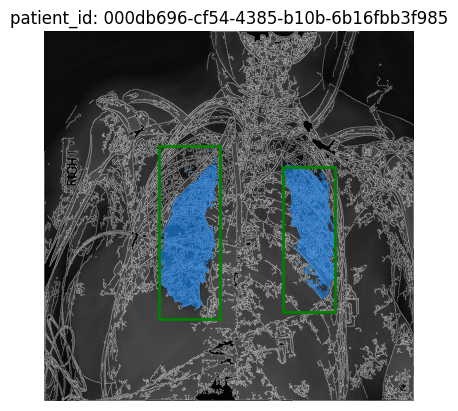

In [20]:
# Iterate through the first 2 keys of the bounding_boxes_dict
counter = 0
for patient_id, boxes in list(bounding_boxes_dict.items())[:1]:  # Process the first entry
    print(counter)
    counter += 1
    
    # Read the DICOM file for the current patient_id
    dcm_file_path = f'cleaned_train_data/cleaned_stage_2_train_images/{patient_id}.dcm'
    output_image_path = f'{output_folder}{patient_id}_sam2_masked.png'
    dicom = pydicom.dcmread(dcm_file_path)
    
    # Convert to 3-channel RGB image if needed by SAM
    image = dicom.pixel_array
    image = np.array(image)
    
    # Apply CLAHE and Canny edge detection
    clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32,32))
    clahe_canny_image = apply_canny_to_array(clahe_image)
    
    # Convert images to RGB
    clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)
    
    # Display the processed image
    plt.imshow(clahe_canny_image_rgb)
    plt.title(f"patient_id: {patient_id}")
    
    # Set the processed image in SAM's predictor
    predictor3.set_image(clahe_canny_image_rgb)

    # Initialize an empty list to hold all the masks and scores
    all_masks = []
    all_scores = []

    # Loop over each bounding box and predict masks one at a time
    for box in boxes:
        input_box = np.array(box)
        
        # Obtain masks and scores for each bounding box
        masks, scores, _ = predictor3.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # Use individual bounding box
            multimask_output=False
        )
        
        # Append the mask and confidence score
        all_masks.append(masks[0])  # Store the mask for each box
        all_scores.append(scores[0])  # Store the confidence score for each mask

    # Display the results and confidence scores
    for mask, score, box in zip(all_masks, all_scores, boxes):
        show_mask(mask, plt.gca())  # Display mask
        show_box(box, plt.gca())
        print(f"Confidence score: {score}")  # Print confidence score for each mask
    
    plt.axis('off')
    # plt.savefig(output_image_path, format='png', dpi=300)  # Save the output image if needed
    plt.show()
    
    # Cleanup to free memory
    plt.clf()
    plt.close('all')
    del dicom, image, clahe_image, clahe_canny_image_rgb, all_masks, all_scores
    gc.collect()


In [23]:
# Initialize lists to hold each row for the final DataFrame and regression model data
data_rows = []
total_bounding_boxes = sum(len(boxes) for boxes in bounding_boxes_dict.values())
modified_boxes = np.zeros(shape=(total_bounding_boxes, 4, 4))
sam_scores = np.zeros(shape=(total_bounding_boxes, 4))
consistency_scores_before = np.zeros(shape=(total_bounding_boxes))
consistency_scores_after = np.zeros(shape=(total_bounding_boxes))
index = 0

iteration = 0  # Track the current iteration

# Loop through each patient and bounding box set
for patient_id, boxes in list(bounding_boxes_dict.items())[:4500]:  # Iterating through each patient and their boxes
    print(f"Processing patient_id: {patient_id} ({iteration + 1}/4500)")
    iteration += 1

    # Read the DICOM file for the current patient_id
    dcm_file_path = f'{input_folder}{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    image = np.array(dicom.pixel_array)

    # Loop through each bounding box
    for box in boxes:
        perturbed_boxes = modify_bounding_boxes([box])

        # Initialize placeholders for SAM scores
        sam_scores_no_prep = np.zeros(len(perturbed_boxes))
        sam_scores_with_prep = np.zeros(len(perturbed_boxes))

        # Pass the original image to SAM for feature extraction
        predictor3.set_image(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

        # Compute SAM scores without preprocessing
        for i, perturbed_box in enumerate(perturbed_boxes):
            input_box = np.array(perturbed_box)
            masks, scores, _ = predictor3.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            best_idx = np.argmax(scores)
            sam_scores_no_prep[i] = scores[best_idx]

        # Calculate consistency score and average SAM score without preprocessing
        consistency_score_before = np.std(sam_scores_no_prep)
        average_sam_score_before = np.mean(sam_scores_no_prep)

        # Apply CLAHE and Canny edge detection for preprocessing
        clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32, 32))
        clahe_canny_image = apply_canny_to_array(clahe_image)
        clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)
        predictor3.set_image(clahe_canny_image_rgb)

        # Compute SAM scores with preprocessing
        for i, perturbed_box in enumerate(perturbed_boxes):
            input_box = np.array(perturbed_box)
            masks, scores, _ = predictor3.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            best_idx = np.argmax(scores)
            sam_scores_with_prep[i] = scores[best_idx]

        # Calculate consistency score and average SAM score with preprocessing
        consistency_score_after = np.std(sam_scores_with_prep)
        average_sam_score_after = np.mean(sam_scores_with_prep)

        # Store in arrays for model training
        for j in range(4):
            modified_boxes[index][j] = perturbed_boxes[j]
            sam_scores[index][j] = sam_scores_with_prep[j]

        # Store the consistency scores and average SAM scores
        consistency_scores_before[index] = consistency_score_before
        consistency_scores_after[index] = consistency_score_after

        # Append to data_rows with new average SAM score columns
        data_rows.append({
            'patient_id': patient_id,
            'consistency_score_before': consistency_score_before,
            'consistency_score_after': consistency_score_after,
            'sam_score_before': average_sam_score_before,
            'sam_score_after': average_sam_score_after
        })

        index += 1

    del dicom, image, clahe_image, clahe_canny_image_rgb
    gc.collect()

# Train the model on the first 4500 images
flattened_boxes_train = modified_boxes[:index].reshape(index, -1)
flattened_sam_scores_train = sam_scores[:index].reshape(index, -1)
model_before = train_regression_model(flattened_boxes_train, flattened_sam_scores_train, consistency_scores_before[:index])
model_after = train_regression_model(flattened_boxes_train, flattened_sam_scores_train, consistency_scores_after[:index])

# Use the trained model to predict consistency scores for the remaining images
for iteration, (patient_id, boxes) in enumerate(list(bounding_boxes_dict.items())[4500:], start=4500):
    print(f"Predicting for patient_id: {patient_id} ({iteration+1}/1512)")

    # Read the DICOM file for the current patient_id
    dcm_file_path = f'{input_folder}{patient_id}.dcm'
    dicom = pydicom.dcmread(dcm_file_path)
    image = np.array(dicom.pixel_array)

    # Loop through each bounding box
    for box in boxes:
        perturbed_boxes = modify_bounding_boxes([box])

        # Pass the preprocessed image to SAM to get SAM scores with preprocessing
        clahe_image = apply_clahe_to_array(image, clip_limit=1.0, tile_grid_size=(32, 32))
        clahe_canny_image = apply_canny_to_array(clahe_image)
        clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)
        predictor3.set_image(clahe_canny_image_rgb)

        sam_scores_with_prep = np.zeros(len(perturbed_boxes))
        for i, perturbed_box in enumerate(perturbed_boxes):
            input_box = np.array(perturbed_box)
            masks, scores, _ = predictor3.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            best_idx = np.argmax(scores)
            sam_scores_with_prep[i] = scores[best_idx]

        # Flatten modified_boxes and sam_scores for model input
        flattened_boxes = np.array(perturbed_boxes).reshape(1, -1)
        flattened_sam_scores = sam_scores_with_prep.reshape(1, -1)

        # Predict consistency scores
        predicted_score_before = predict_consistency(model_before, flattened_boxes, flattened_sam_scores)
        predicted_score_after = predict_consistency(model_after, flattened_boxes, flattened_sam_scores)

        # Calculate average SAM scores
        average_sam_score_before = np.mean(sam_scores_no_prep)
        average_sam_score_after = np.mean(sam_scores_with_prep)

        # Append predicted scores and average SAM scores to data_rows
        data_rows.append({
            'patient_id': patient_id,
            'consistency_score_before': predicted_score_before[0],
            'consistency_score_after': predicted_score_after[0],
            'sam_score_before': average_sam_score_before,
            'sam_score_after': average_sam_score_after
        })

    del dicom, image, clahe_image, clahe_canny_image_rgb
    gc.collect()

# Save final results to CSV
output_df = pd.DataFrame(data_rows)
output_csv_path = "trained_consistency_scores.csv"
output_df.to_csv(output_csv_path, index=False)
print(output_df)


Processing patient_id: 000db696-cf54-4385-b10b-6b16fbb3f985 (1/4500)
Processing patient_id: 000fe35a-2649-43d4-b027-e67796d412e0 (2/4500)
Processing patient_id: 001031d9-f904-4a23-b3e5-2c088acd19c6 (3/4500)
Processing patient_id: 001916b8-3d30-4935-a5d1-8eaddb1646cd (4/4500)
Processing patient_id: 0022073f-cec8-42ec-ab5f-bc2314649235 (5/4500)
Processing patient_id: 002cb550-2e31-42f1-a29d-fbc279977e71 (6/4500)
Processing patient_id: 00436515-870c-4b36-a041-de91049b9ab4 (7/4500)
Processing patient_id: 00704310-78a8-4b38-8475-49f4573b2dbb (8/4500)
Processing patient_id: 0087bd3a-55a7-4045-b111-b018fa52d361 (9/4500)
Processing patient_id: 00a05408-8291-4231-886e-13763e103161 (10/4500)
Processing patient_id: 00aecb01-a116-45a2-956c-08d2fa55433f (11/4500)
Processing patient_id: 00c0b293-48e7-4e16-ac76-9269ba535a62 (12/4500)
Processing patient_id: 00eeb3c9-a892-4fac-a67a-aaa6cc7ffd5c (13/4500)
Processing patient_id: 00f08de1-517e-4652-a04f-d1dc9ee48593 (14/4500)
Processing patient_id: 010051